# Proyecto N° 1 : Desafío Perceptrón

## Modelo Perceptrón

Primero convertimos nuestras muestras de audio etiquetadas en muestras bidimensionales, utilizando la "caja negra" llamada $t-\mathtt{SNE}$

In [1]:
#!pip install transformers
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import sklearn
from transformers import AutoFeatureExtractor #generador de características
### Fijar antes la semilla
### Just in Colab
# from google.colab import files
# from google.colab import drive
# drive.mount("/content/drive")

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/envs/ambiente-audio-2023/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%cd /content/drive/MyDrive/Introducción al Machine Learning con aplicaciones al Audio/Colabs

In [3]:
### Just in google colab
#MyPath = pathlib.Path("/content/drive/MyDrive/Introducción al Machine Learning con aplicaciones al Audio/Colabs/Proyecto 2 - Clasificación Binaria Perceptrón/Data")

### Camino para encontrar los datos
MyPath = pathlib.Path('/Users/rodolfolobocarrasco/Desktop/Audio_Machine_Learning/projects/project_1/solution/data')

In [4]:
sr = 16000    # sampling rate

kick_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('kick/Copia de Bass Sample *.wav')
]

snare_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('snare/Copia de Snare Sample *.wav')
]

In [5]:
len(kick_signals), len(snare_signals)

(40, 40)

In [6]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/envs/ambiente-audio-2023/lib/python3.11/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [7]:
kick_inputs = feature_extractor(kick_signals, sampling_rate=sr, return_tensors="pt")
snare_inputs = feature_extractor(snare_signals, sampling_rate=sr, return_tensors="pt")

In [8]:
kick_inputs['input_values'].shape

torch.Size([40, 32000])

In [9]:
kick_embeddings = kick_inputs['input_values']
snare_embeddings = snare_inputs['input_values']
kick_embeddings

tensor([[-1.7832e-03,  2.4984e-02,  1.2950e-01,  ..., -1.2582e-04,
         -1.9313e-04, -2.0474e-04],
        [-9.3932e-02,  1.0399e+00,  3.4948e+00,  ..., -9.2887e-04,
         -9.2703e-04, -9.4120e-04],
        [-6.5191e-02,  7.4499e-02, -8.0793e-02,  ..., -2.4098e-03,
         -2.0295e-03, -2.6402e-03],
        ...,
        [ 1.1908e-02, -1.6354e-02,  1.5784e-02,  ..., -6.1299e-04,
         -6.6546e-04, -9.1216e-04],
        [ 4.1040e-03, -4.4799e-03,  1.5916e-03,  ...,  1.9959e-04,
          1.9348e-04,  1.8768e-04],
        [-6.9040e-02,  7.4369e-02, -7.2024e-02,  ...,  1.6052e-03,
          1.5155e-03,  1.8443e-03]])

In [10]:
import torch

X = torch.cat((kick_embeddings, snare_embeddings), 0)
X.shape
X

tensor([[-1.7832e-03,  2.4984e-02,  1.2950e-01,  ..., -1.2582e-04,
         -1.9313e-04, -2.0474e-04],
        [-9.3932e-02,  1.0399e+00,  3.4948e+00,  ..., -9.2887e-04,
         -9.2703e-04, -9.4120e-04],
        [-6.5191e-02,  7.4499e-02, -8.0793e-02,  ..., -2.4098e-03,
         -2.0295e-03, -2.6402e-03],
        ...,
        [ 1.3791e-01, -8.5072e-01, -2.5005e+00,  ..., -4.5005e-03,
         -6.1739e-03, -7.1491e-03],
        [-4.9274e-02, -2.2554e-01, -4.9349e+00,  ..., -2.1222e-03,
         -2.5972e-03, -2.3859e-03],
        [ 1.5733e-02, -6.2977e-01, -5.8296e+00,  ..., -2.1159e-03,
         -1.5933e-04, -1.1096e-03]])

In [11]:
from sklearn import manifold

tsne = manifold.TSNE(n_components = 2, random_state = 42)
transformed_data = tsne.fit_transform(X)

In [12]:
transformed_data.shape

(80, 2)

In [13]:
import pandas as pd

df_tsne = pd.DataFrame(transformed_data)
df_tsne['targets'] = 40*[1] + 40*[0]

In [14]:
df_tsne.columns = ['Feature 1','Feature 2','classes']

In [15]:
df_tsne.head(5)

,Feature 1,Feature 2,classes
0,6.611866,-4.113020,1
1,5.500803,-3.785679,1
2,3.845456,-4.395586,1
3,5.514779,0.884576,1
4,5.434247,-1.393771,1


Visualización de nuestras muestras, cada una representada por dos características.

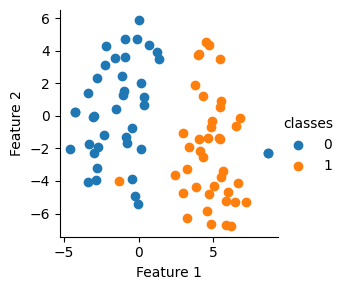

In [17]:
import seaborn as sns

grid = sns.FacetGrid(df_tsne,hue = "classes")
grid.map(plt.scatter,"Feature 1","Feature 2").add_legend()

# plt.savefig("dataset.png")
# files.download("dataset.png")

División del dataset en datos de entrenamiento y en datos de testeo.

In [18]:
from sklearn.model_selection import train_test_split

inputs, targets = df_tsne.iloc[:, 0:2],df_tsne.iloc[:, 2]      # separamos las columnas de los features la de targets

X = torch.Tensor(inputs.to_numpy(dtype=float))                 # transormamos a tensores los datos
Y = torch.Tensor(targets.to_numpy(dtype=float))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)    # dividimos el dataset en train y test

In [19]:
len(X_test)

27

Visualización de nuestros datos de entrenamiento y de testeo

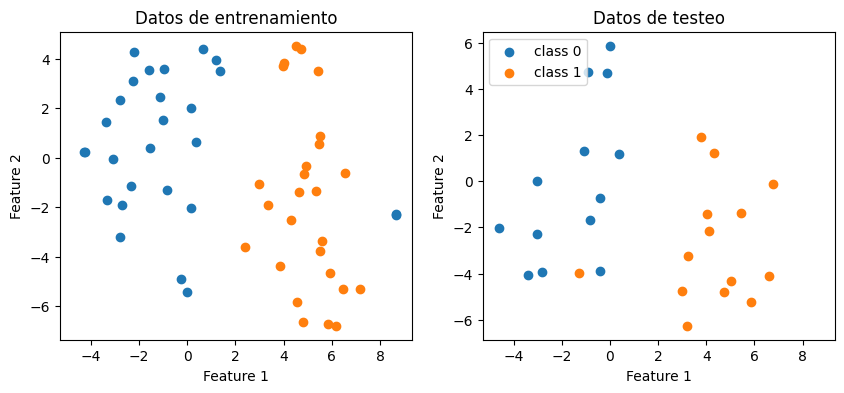

In [20]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1')
ax[0].title.set_text("Datos de entrenamiento")
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1')
ax[1].title.set_text("Datos de testeo")
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')

ax[1].legend(loc='upper left')

# plt.savefig("split_dataset.png")
# files.download("split_dataset.png")
plt.show()


In [21]:
seed = 42  # Elegimos una semilla de números aleatorios

# Fijamos la semilla en la CPU
torch.manual_seed(seed) #fijamos una semilla para poder reproducir los números aleatorios del cuaderno

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Definimos la clase Perceptrón

In [23]:

### faltò agregar docs!
class Perceptron():
        """
            add docs
        """
    def __init__(self, num_features = 2):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32)
        self.bias = torch.zeros(1, dtype=torch.float32)

        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        """
            add docs
        """
        ### ¿que es mm?
        linear = torch.mm(x, self.weights) + self.bias
        
        ### ¿cómo funciona where?
        y_pred = torch.where(linear > 0., self.ones, self.zeros)        # funcion de activacion
        return y_pred

    def backward(self, x, y):
        """
            add docs
        """
        y_pred = self.forward(x)
        error = y - y_pred
        return error

    def train(self, x, y, epochs, learning_rate = 0.01):
        """
            add docs
        """
        for epoch in range(epochs):

            for i in range(y.shape[0]):

                error = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (error * x[i] * learning_rate).reshape(self.num_features, 1)
                self.bias += error * learning_rate
            print(f'Epoch [{epoch+1}/{epochs}]')

    def evaluate(self, x, y):
        """
            add docs
        """
        ### ¿qué significa reshape(-1)?
        y_pred = self.forward(x).reshape(-1)
        accuracy = accuracy_score(y, y_pred)
        return accuracy

    def confusion_matrix(self, y, y_pred):
        """
            add docs
        """
        cm = confusion_matrix(y, y_pred)
        return cm

Instanciamos nuestro modelo y lo entrenamos con las datos de entrenamiento

In [24]:
modelo = Perceptron()
modelo.train(X_train, y_train, epochs=20)

Epoch [1/20]
Epoch [2/20]
Epoch [3/20]
Epoch [4/20]
Epoch [5/20]
Epoch [6/20]
Epoch [7/20]
Epoch [8/20]
Epoch [9/20]
Epoch [10/20]
Epoch [11/20]
Epoch [12/20]
Epoch [13/20]
Epoch [14/20]
Epoch [15/20]
Epoch [16/20]
Epoch [17/20]
Epoch [18/20]
Epoch [19/20]
Epoch [20/20]


Evaluamos la performance para el conjunto de entrenamiento: primero calculamos el valor de accuracy

In [25]:
accuracy_train = modelo.evaluate(X_train, y_train)
print(f"Accuracy: {accuracy_train * 100:.2f}%")

Accuracy: 92.45%


Y luego graficamos su matriz de confusión

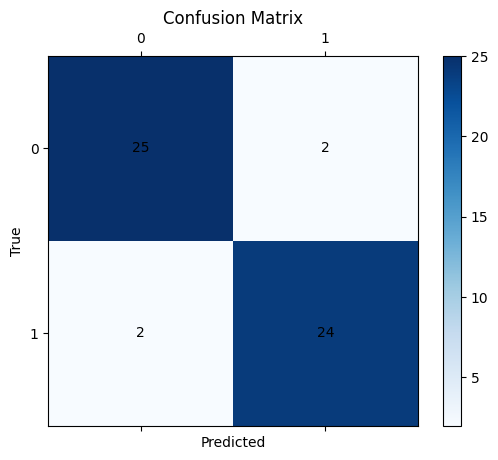

In [26]:
y_pred = modelo.forward(X_train)
cm = modelo.confusion_matrix(y_train, y_pred)

# Visualize the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), va='center', ha='center')

# plt.savefig("cm_train_perceptron.png")
# files.download("cm_train_perceptron.png")
plt.show()

A continuación evaluamos la perfomance con el conjunto de testeo

In [27]:
accuracy_test = modelo.evaluate(X_test, y_test)
print(f"Accuracy (test): {accuracy_test * 100:.2f}%")

Accuracy (test): 96.30%


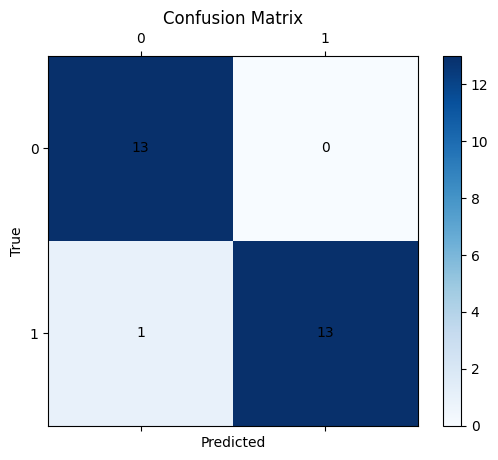

In [28]:
y_pred = modelo.forward(X_test)
cm = modelo.confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), va='center', ha='center')

# plt.savefig("cm_test_perceptron.png")
# files.download("cm_test_perceptron.png")
plt.show()

Finalmente tenemos un gráfico con la frontera de desición establecida por nuestro modelo

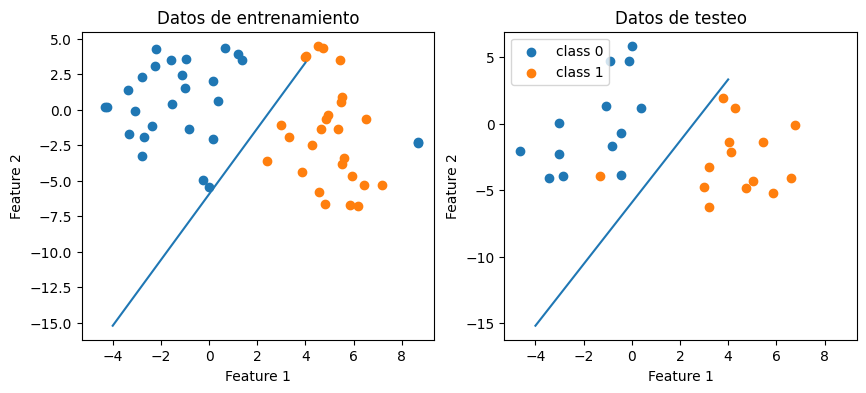

In [29]:
w, b = modelo.weights, modelo.bias

x0_min = -4
x1_min = ( (-(w[0] * x0_min) - b[0])
          / w[1] )

x0_max = 4
x1_max = ( (-(w[0] * x0_max) - b[0])
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1')
ax[0].title.set_text("Datos de entrenamiento")
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1')
ax[1].title.set_text("Datos de testeo")
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')

ax[1].legend(loc='upper left')

# plt.savefig("dataset_frontera.png")
# files.download("dataset_frontera.png")
plt.show()

## Modelo de Regresión Logística

Instanciamos nuestro modelo de Regresión Logística y entrenamos

In [30]:
from sklearn.linear_model import LogisticRegression

lr_modelo = LogisticRegression(max_iter = 1000)
lr_modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Evaluamos la performance de nuestro modelo con los datos de entrenamiento

In [31]:
y_predicted = lr_modelo.predict(X_train)
accuracy = accuracy_score(y_train, y_predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.23%


Y graficamos su matriz de confusión

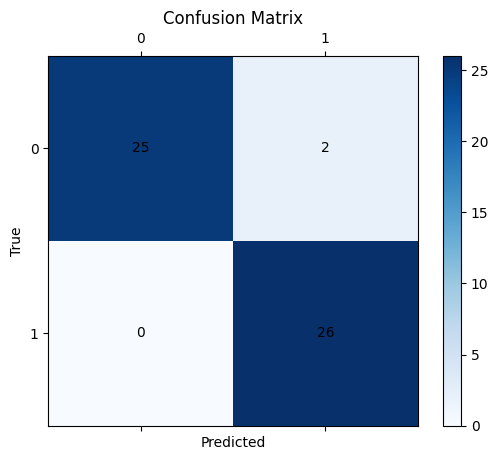

In [32]:
# Compute confusion matrix
cm2 = confusion_matrix(y_train, y_predicted)

# Visualize the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm2, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(cm2.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm2[i, j]), va='center', ha='center')

# plt.savefig("cm_train_regresion.png")
# files.download("cm_train_regresion.png")
plt.show()

Ahora evaluamos la performance para el conjunto de testeo

In [33]:
y_predicted = lr_modelo.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.30%


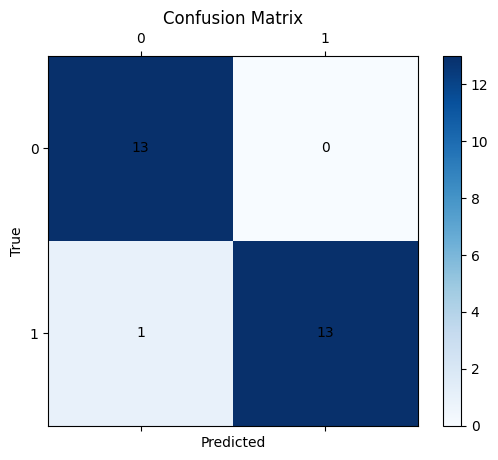

In [34]:
# Compute confusion matrix
cm2 = confusion_matrix(y_test, y_predicted)

# Visualize the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm2, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(cm2.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm2[i, j]), va='center', ha='center')

# plt.savefig("cm_test_regresion.png")
# files.download("cm_test_regresion.png")
plt.show()